In [1]:
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import time
from ensembles import *
from sklearn.datasets import make_regression
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import minimize_scalar
from sklearn.model_selection import train_test_split

## Эксперименты

### 1. Загрузка и предварительная обработка датасета
Загрузим датасет о продаже недвижности

In [2]:
X = pd.read_csv('train_data.csv')
y = pd.read_csv('train_target.csv')
X.info(), y.keys()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           17280 non-null  int64  
 1   id                              17280 non-null  int64  
 2   date                            17280 non-null  object 
 3   bedrooms_number                 17280 non-null  int64  
 4   batchrooms_number               17280 non-null  float64
 5   square_footage_home             17280 non-null  int64  
 6   square_footage_lot              17280 non-null  int64  
 7   floors_number                   17280 non-null  float64
 8   has_waterfront                  17280 non-null  int64  
 9   has_been_viewed                 17280 non-null  int64  
 10  condition_quality               17280 non-null  int64  
 11  housing_unity_grade             17280 non-null  int64  
 12  square_footage_except_basement  

(None, Index(['index', 'price'], dtype='object'))

Как видно, столбцы индексов и даты не несут смысловой нагрузки, данные полны (без пропусков), все признаки после удаления даты вещественны. 

In [3]:
X = X.drop(columns=['index', 'id', 'date'])
y = y['price']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=42, test_size=0.3)

### 2. Работа случайного леса

Исследуем поведение случайного леса. Снимем зависимость RMSE на отложенной выборке и время работы алгоритма от 
- количества деревьев
- размерности подвыборки признакового пространства для одного дерева
- максимальной глубины дерева (вклчая неограниченную)

количества деревьев. Максимальную глубину оставим 10. Поскольку у нас деревья строятся не параллельно (в отличие от sklearn), то это занимает достаточно много времени. В связи с этим, будем перебирать гиперпараметр с достаточно большим шагом (добавлять по 100 деревьев).

In [5]:
def RMSE(y, y_pred):
    return np.sqrt(((y - y_pred) ** 2).mean())

def fit_rmse_time(regressor):
    start = time.time()
    regressor.fit(X_train, y_train)
    rmse = RMSE(y_test, regressor.predict(X_test))
    return rmse, time.time() - start

def plot(x, xlabel):
    fig = plt.figure(figsize=(16, 4))
    for i, ylabel in enumerate(('RMSE', 'time, sec')):
        ax = fig.add_subplot(121+i)
        ax.plot(x, rmse_time[:,i], marker='.')
        ax.set(xlabel=xlabel, ylabel=ylabel, title='Зависимость ' + ylabel + ' от ' + xlabel)

#### Количество деревьев

CPU times: user 5.08 s, sys: 946 ms, total: 6.02 s
Wall time: 54.9 s


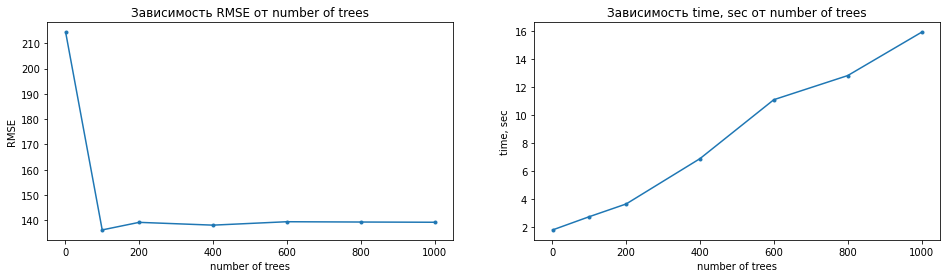

In [6]:
%%time
n_trees = [1, 100, 200, 400, 600, 800, 1000]
rmse_time = np.empty((len(n_trees), 2))

for i, n in enumerate(n_trees):
    forest = RandomForestMSE(n_estimators=n, max_depth=10, n_jobs=-1)
    rmse_time[i] = fit_rmse_time(forest)
plot(n_trees, 'number of trees')

Заметим, что брать количество деревьев больше 200 не имеет смысла, так как RMSE перестает изменяться при увеличении, в отличие от времени, которое неумолимо увеличивается. 

#### Глубина деревьев (включая неограниченный вариант)

CPU times: user 8.12 s, sys: 1.67 s, total: 9.79 s
Wall time: 1min


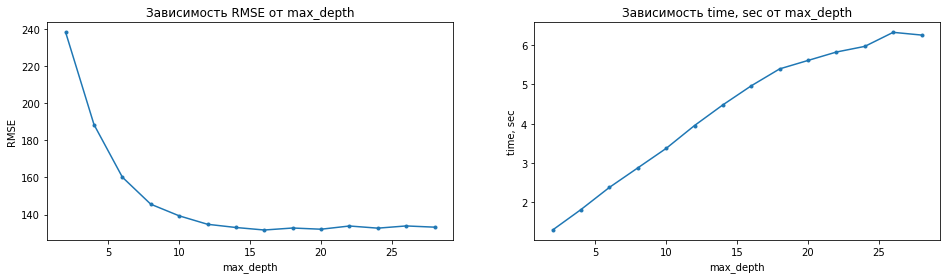

In [7]:
%%time
max_depth = range(2, 30, 2)
rmse_time = np.empty((len(max_depth), 2))

for i, d in enumerate(max_depth):
    forest = RandomForestMSE(n_estimators=200, max_depth=d, n_jobs=-1)
    rmse_time[i] = fit_rmse_time(forest)
plot(max_depth, 'max_depth')

Оптимальной глубиной назовем 15 - первую точку (c наименьшим временем) стабилизации RMSE (после этой точки можем считать RMSE прямой линией).

Без ограничения на глубину:

In [8]:
forest = RandomForestMSE(n_estimators=200, max_depth=None, n_jobs=-1)
rmse, time = fit_rmse_time(forest)
print('RMSE: {:.3f}  time: {:.3f} sec'.format(rmse, time))

RMSE: 133.963  time: 6.316 sec


В результате для маленькой глубины модель не обнаруживает правильных закономерностей и выдает плохое качество. После 15 показания стабилизируются. Однако чем больше глубина, тем сильнее модель переобучается, приводя к плохому результату на тестовой выборке.

In [13]:
import time

#### Размерность признаков

CPU times: user 5.63 s, sys: 890 ms, total: 6.52 s
Wall time: 1min 6s


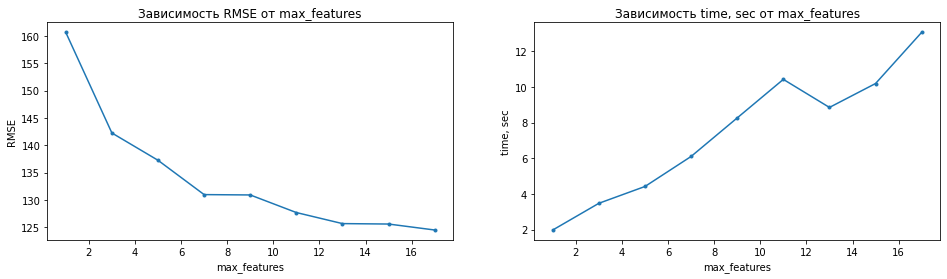

In [14]:
%%time
max_features = range(1, 18, 2)
rmse_time = np.empty((len(max_features), 2))

for i, f in enumerate(max_features):
    forest = RandomForestMSE(n_estimators=200, max_depth=15, feature_subsample_size=f, n_jobs=-1)
    rmse_time[i] = fit_rmse_time(forest)
plot(max_features, 'max_features')

Логичный результат: чем меньше размерность признакового пространства, тем хуже модель. Однако зависимость не линейная и кривая уже к 11 признаку выходит на плато. 

## Градиентный бустинг

#### Количество деревьев

CPU times: user 2min 23s, sys: 0 ns, total: 2min 23s
Wall time: 2min 24s


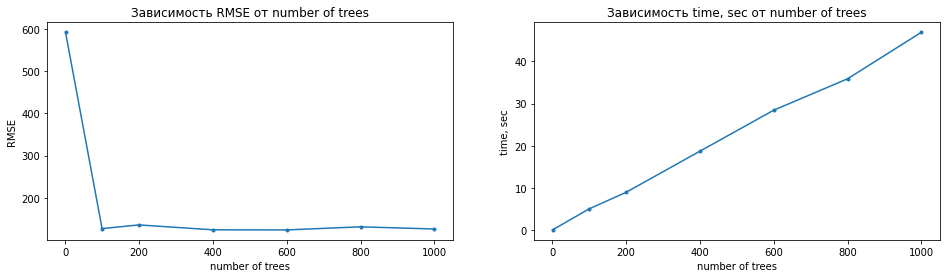

In [15]:
%%time
n_trees = [1, 100, 200, 400, 600, 800, 1000]
rmse_time = np.empty((len(n_trees), 2))

for i, n in enumerate(n_trees):
    gb = GradientBoostingMSE(n_estimators=n, max_depth=10)
    rmse_time[i] = fit_rmse_time(gb)
plot(n_trees, 'number of trees')

Заметим, что брать количество деревьев больше 200 не имеет смысла, так как RMSE перестает изменяться при увеличении, в отличие от времени, которое неумолимо увеличивается. 

#### Глубина деревьев (включая неограниченный вариант)

CPU times: user 2min 42s, sys: 553 ms, total: 2min 43s
Wall time: 18h 41min 26s


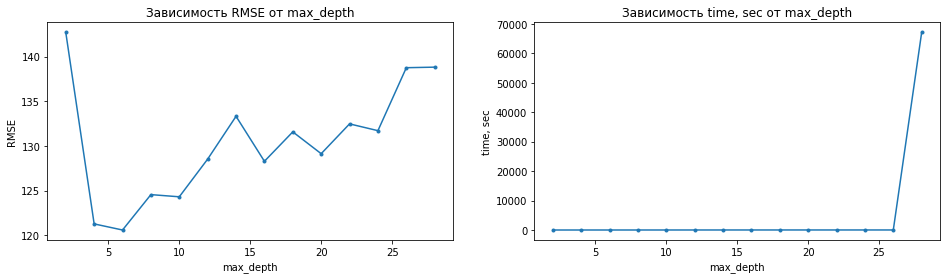

In [16]:
%%time
max_depth = range(2, 30, 2)
rmse_time = np.empty((len(max_depth), 2))

for i, d in enumerate(max_depth):
    gb = GradientBoostingMSE(n_estimators=200, max_depth=d)
    rmse_time[i] = fit_rmse_time(gb)
plot(max_depth, 'max_depth')

Чрезвычайно приятно выглядит глубина от 4 до 8. 

Без ограничения на глубину:

In [17]:
gb = GradientBoostingMSE(n_estimators=200, max_depth=None)
rmse, time = fit_rmse_time(gb)
print('RMSE: {:.3f}  time: {:.3f} sec'.format(rmse, time))

RMSE: 128.089  time: 17.466 sec


Видно, что при довольно большой глубине (после 10) модель переобучается, приводя к плохому качеству, поэтому считаем оптимальной 8. 

#### Размерность признаков

In [18]:
%%time
max_features = range(1, 18, 2)
rmse_time = np.empty((len(max_features), 2))

for i, f in enumerate(max_features):
    gb = GradientBoostingMSE(n_estimators=200, max_depth=8, feature_subsample_size=f)
    rmse_time[i] = fit_rmse_time(gb)
plot(max_features, 'max_features')

AttributeError: 'float' object has no attribute 'time'

В результате оптимальным числом признаков можно назначить 11.

#### learning_rates

In [19]:
%%time
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.25, 1.0, 1.25]
rmse_time = np.empty((len(learning_rates), 2))

for i, r in enumerate(learning_rates):
    gb = GradientBoostingMSE(n_estimators=200, max_depth=10, learning_rate=r)
    rmse_time[i] = fit_rmse_time(gb)
plot(learning_rates, 'learning_rates')

AttributeError: 'float' object has no attribute 'time'

С учетом, что разница во времени не слишком существенна, самый лучший результат дает learning_rate = 0.1